# Skin Classification

Link dataset: [https://www.kaggle.com/datasets/rajeshpandhare/skin-classification-normal-acne-oily-dry-wrinkle](https://www.kaggle.com/datasets/rajeshpandhare/skin-classification-normal-acne-oily-dry-wrinkle)

In [8]:
# Jalankan ini kalau ultralytics / opencv / scikit-learn belum terinstall
# Di Jupyter lokal: hapus "!" kalau pakai terminal/conda
!pip install -U ultralytics opencv-python scikit-learn

In [9]:
import os
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt

# Matikan Weights & Biases supaya tidak minta API key
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"

from ultralytics import YOLO
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
)
from PIL import Image

In [10]:
# GANTI path ini sesuai lokasi dataset-mu
# Colab (contoh):
DATASET_PATH = "/content/drive/MyDrive/Compro/dataset/skin_dataset"

# Jupyter lokal (contoh):
# DATASET_PATH = r"D:\Projek\skin_dataset"

DATASET_DIR = Path(DATASET_PATH)

print("Subfolder di dataset (harus ada train & val):")
for p in DATASET_DIR.iterdir():
    print("-", p)

train_dir = DATASET_DIR / "train"
classes = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])

print("\nKelas yang terdeteksi di train/:")
for c in classes:
    print("-", c)


Subfolder di dataset (harus ada train & val):
- /content/drive/MyDrive/Compro/dataset/skin_dataset/val
- /content/drive/MyDrive/Compro/dataset/skin_dataset/train
- /content/drive/MyDrive/Compro/dataset/skin_dataset/train.cache
- /content/drive/MyDrive/Compro/dataset/skin_dataset/val.cache

Kelas yang terdeteksi di train/:
- Acne
- Blackheads
- Dark Spots
- Dry Skin
- Normal Skin
- Oily Skin
- Wrinkles


Menampilkan 5 gambar dari split='train', kelas='Dark Spots' (total 98)


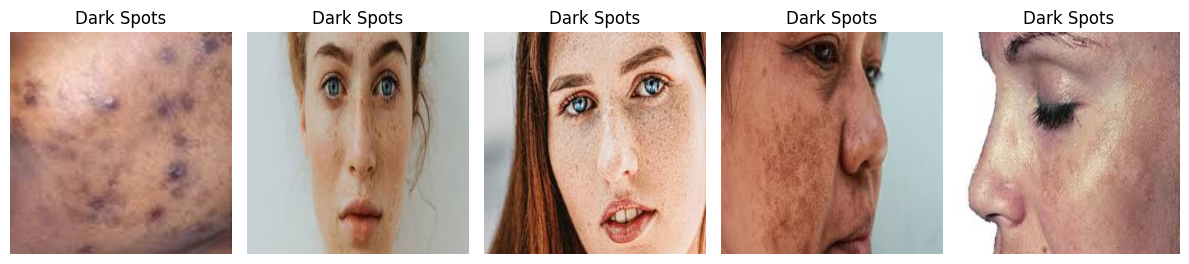

In [11]:
def show_random_images(split="train", cls=None, n=5):
    """
    Menampilkan beberapa gambar contoh dari split (train/val) dan kelas tertentu.
    """
    split_dir = DATASET_DIR / split

    if cls is None:
        cls = random.choice(classes)

    cls_dir = split_dir / cls
    images = list(cls_dir.glob("*"))

    if len(images) == 0:
        print(f"Tidak ada gambar di split='{split}', kelas='{cls}'")
        return

    print(f"Menampilkan {n} gambar dari split='{split}', kelas='{cls}' (total {len(images)})")

    n = min(n, len(images))
    sample_imgs = random.sample(images, n)

    plt.figure(figsize=(12, 4))
    for i, img_path in enumerate(sample_imgs):
        img = plt.imread(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls)
    plt.tight_layout()
    plt.show()


# Contoh pakai:
show_random_images("train")      # atau show_random_images("val", "Acne", 4)


In [12]:
def train_skin_classifier(
    data_path: str,
    model_name: str = "yolov8s-cls.pt",
    epochs: int = 50,
    imgsz: int = 224,
    batch: int = 32,
    run_name: str = "yolov8s_skin",
):
    """
    Melatih model YOLOv8 classification untuk dataset jenis kulit.
    """
    print(f"Memulai training dengan model={model_name}, epochs={epochs}, imgsz={imgsz}, batch={batch}")
    model = YOLO(model_name)

    results = model.train(
        data=data_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        lr0=1e-3,
        patience=10,           # early stopping (bisa diganti 0 kalau mau full epochs)
        project="runs_skin_cls",
        name=run_name,
        verbose=True,
    )

    print("Training selesai.")
    return model, results


In [13]:
model, results = train_skin_classifier(
    data_path=DATASET_PATH,
    model_name="yolov8s-cls.pt",  # kalau terlalu berat, ganti ke 'yolov8n-cls.pt'
    epochs=50,
    imgsz=224,
    batch=32,                     # kalau OOM, turunin ke 16 atau 8
    run_name="yolov8s_skin3",     # ubah nama run kalau mau training ulang
)


Memulai training dengan model=yolov8s-cls.pt, epochs=50, imgsz=224, batch=32
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.9.1+cu128 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Compro/dataset/skin_dataset, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_skin3, nbs=64, nms=False, 

Akurasi pada val set: 1.0000

Classification report:
              precision    recall  f1-score   support

        Acne       1.00      1.00      1.00       106
  Blackheads       1.00      1.00      1.00        90
  Dark Spots       1.00      1.00      1.00        98
    Dry Skin       1.00      1.00      1.00        71
 Normal Skin       1.00      1.00      1.00       112
   Oily Skin       1.00      1.00      1.00       103
    Wrinkles       1.00      1.00      1.00       141

    accuracy                           1.00       721
   macro avg       1.00      1.00      1.00       721
weighted avg       1.00      1.00      1.00       721



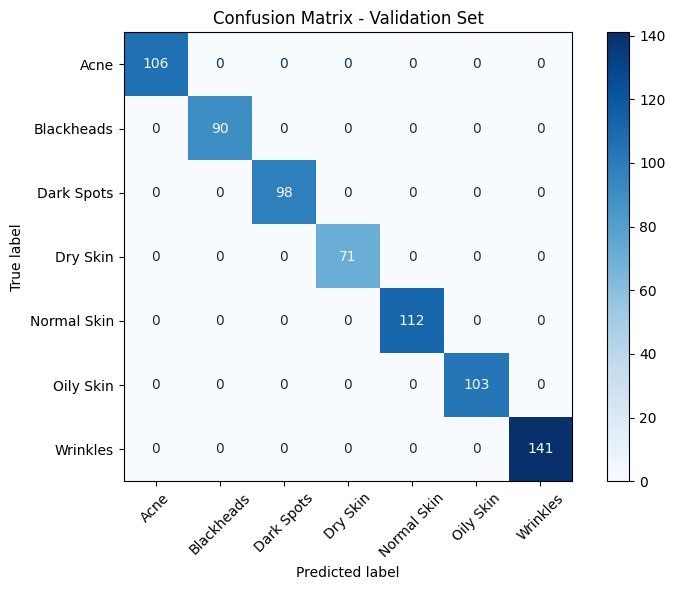

In [14]:
val_dir = DATASET_DIR / "val"

y_true = []
y_pred = []

# Hanya pakai format gambar yang didukung YOLO
allowed_ext = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff", ".heic"}

# Loop semua gambar di folder val/ dan prediksi
for cls in classes:
    cls_dir = val_dir / cls
    img_list = [f for f in cls_dir.glob("*") if f.suffix.lower() in allowed_ext]

    if not img_list:
        print(f"Tidak ada gambar valid di kelas '{cls}' (format yang didukung: {allowed_ext})")
        continue

    for img_path in img_list:
        res = model.predict(source=str(img_path), verbose=False)
        pred = res[0]

        prob_array = pred.probs.data.cpu().numpy()
        top_idx = int(np.argmax(prob_array))
        pred_label = pred.names[top_idx]

        y_true.append(cls)         # label asli = nama folder
        y_pred.append(pred_label)  # label prediksi

# Label unik (gabungan dari yg muncul di true & pred)
labels = sorted(list(set(y_true) | set(y_pred)))

# Hitung metrics
cm = confusion_matrix(y_true, y_pred, labels=labels)
acc = accuracy_score(y_true, y_pred)

print(f"Akurasi pada val set: {acc:.4f}\n")

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=labels))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=True)
plt.title("Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()


In [15]:
def predict_samples_from_val(model, classes, samples_per_class: int = 3):
    """
    Menampilkan hasil prediksi untuk beberapa sampel gambar dari folder val/ setiap kelas.
    """
    allowed_ext = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff", ".heic"}

    for cls in classes:
        cls_dir = val_dir / cls
        img_list = [f for f in cls_dir.glob("*") if f.suffix.lower() in allowed_ext]
        if not img_list:
            continue

        print(f"\nContoh prediksi untuk kelas folder '{cls}'")
        sample_imgs = random.sample(img_list, min(samples_per_class, len(img_list)))

        for img_path in sample_imgs:
            res = model.predict(source=str(img_path), verbose=False)
            pred = res[0]

            prob_array = pred.probs.data.cpu().numpy()
            top_idx = int(np.argmax(prob_array))
            top_conf = float(prob_array[top_idx])
            pred_label = pred.names[top_idx]

            print(f"{img_path.name} -> Pred: {pred_label} ({top_conf:.2f})")


predict_samples_from_val(model, classes, samples_per_class=3)



Contoh prediksi untuk kelas folder 'Acne'
acne-900-_jpeg_jpg.rf.b99ee9ac35c760b56a7533dc005d79d0.jpg -> Pred: Acne (1.00)
acne-333-_jpg.rf.b93dc96d81e84eb3270227cc3df2b595.jpg -> Pred: Acne (1.00)
acne-9-_jpg.rf.9117fc4817b49e91ff9b0b082ca185bb.jpg -> Pred: Acne (1.00)

Contoh prediksi untuk kelas folder 'Blackheads'
37_jpg.rf.6bfa0170406cc6db08bf8c3d0314d6c9 copy 2.jpg -> Pred: Blackheads (1.00)
144_jpg.rf.b97ca48ac58be710eace9b625e42d596 copy.jpg -> Pred: Blackheads (1.00)
2_jpg.rf.9fe3c6ac82cc448b8672ee299b18d29d copy.jpg -> Pred: Blackheads (1.00)

Contoh prediksi untuk kelas folder 'Dark Spots'
Image_5_jpg.rf.957d6a80ad69c44728c51887175663f0.jpg -> Pred: Dark Spots (1.00)
Image_111_jpg.rf.3457ea00f4b4133a9977048df1bd46c6.jpg -> Pred: Dark Spots (1.00)
69_jpg.rf.52751dce7d8ca05c21380639a97c5829.jpg -> Pred: Dark Spots (1.00)

Contoh prediksi untuk kelas folder 'Dry Skin'
kering__-34-_jpg.rf.92104607c21ea19d0bfdce4df97fa5d3.jpg -> Pred: Dry Skin (1.00)
6b0bbb7874796fd11f8edb526cba4

Gambar: https://nose.co.id/src/blog/FOTO_BLOG_Kulit_Jerawat_%282%29.jpg
Prediksi jenis kulit : Dark Spots
Confidence           : 0.9799


Probabilitas tiap kelas:
- Acne            : 0.0003
- Blackheads      : 0.0000
- Dark Spots      : 0.9799
- Dry Skin        : 0.0008
- Normal Skin     : 0.0001
- Oily Skin       : 0.0189
- Wrinkles        : 0.0000


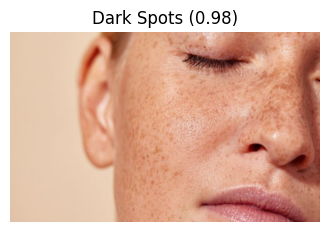

In [30]:
import requests
from io import BytesIO
def predict_single_image(model, image_path: str, show_image: bool = True):
    """
    Prediksi jenis kulit dari satu gambar.
    Bisa memproses gambar dari:
    - Local path
    - Google Drive path
    - URL (http/https)
    """

    # Jika input adalah URL
    if image_path.startswith("http://") or image_path.startswith("https://"):
        try:
            response = requests.get(image_path, timeout=10)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert("RGB")
            temp_path = "temp_input_image.jpg"
            img.save(temp_path)
            input_path = temp_path
            is_url = True
        except Exception as e:
            print("Gagal mendownload gambar dari URL:", e)
            return
    else:
        input_path = image_path
        is_url = False

    # Prediksi memakai YOLO
    res = model.predict(source=input_path, verbose=False)
    pred = res[0]

    prob_array = pred.probs.data.cpu().numpy()
    top_idx = int(np.argmax(prob_array))
    top_conf = float(prob_array[top_idx])
    pred_label = pred.names[top_idx]

    # Output tekstual
    print(f"Gambar: {image_path}")
    print(f"Prediksi jenis kulit : {pred_label}")
    print(f"Confidence           : {top_conf:.4f}\n")
    print("\nProbabilitas tiap kelas:")
    for idx, name in pred.names.items():
        print(f"- {name:<15} : {prob_array[idx]:.4f}")

    # Tampilkan gambar jika show_image=True
    if show_image:
        if is_url:
            img_to_show = img
        else:
            img_to_show = Image.open(image_path)

        plt.figure(figsize=(4, 4))
        plt.imshow(img_to_show)
        plt.axis("off")
        plt.title(f"{pred_label} ({top_conf:.2f})")
        plt.show()

    # Hapus file temporer dari URL
    if is_url and os.path.exists(temp_path):
        os.remove(temp_path)

test_image_path = "https://nose.co.id/src/blog/FOTO_BLOG_Kulit_Jerawat_%282%29.jpg"

predict_single_image(model, test_image_path)


In [ ]:
# Model terbaik (.pt) otomatis tersimpan di:
# runs_skin_cls/yolov8s_skin/weights/best.pt

# Export ke ONNX (opsional, misal mau dipakai di backend lain)
# model.export(format="onnx")  # menghasilkan file .onnx di folder weights
